<a href="https://colab.research.google.com/github/ben-oxley/colab-opencl-experiments/blob/main/particle-sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyopencl
!pip install pillow
from __future__ import division
import numpy as np
import pyopencl as cl
import pyopencl.array
from pyopencl.clrandom import rand as clrand
import pyopencl.cltypes as cltypes
from PIL import Image
from IPython.display import display

In [2]:
%load_ext pyopencl.ipython_ext

In [3]:
print(pyopencl.get_platforms())
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

[<pyopencl.Platform 'NVIDIA CUDA' at 0x5647572da9e0>]


In [4]:
%%cl_kernel

__kernel void sum_vector(__global float4 *a,
__global const float4 *b)
{
  int gid = get_global_id(0);
  a[gid].x = fmod((a[gid].x + b[gid].x * 1.0),1000.0);
  a[gid].y = fmod((a[gid].y + b[gid].y * 1.0),1000.0);
}

__kernel void to_canvas(__global const float4 *a, __global float *canvas)
{
  int gid = get_global_id(0);
  int x = convert_int(a[gid].x);
  int y = convert_int(a[gid].y)*1000;
  canvas[x+y] +=1;
}

__kernel void force_calc(__global float *mass_map, __global float *force_map)
{
  int gid = get_global_id(0);
  for (int y = -20; y < 21; y++){
    for (int x = -20; x < 21; x++){
        float mass  = mass_map[gid+(x%1000)+(y%1000)*1000];
        //only multiply by mass once as we assume local mass is tiny in relation to remote mass
        if (x == 0 && y == 0){
            x++;
            y++;
        } 
       force_map[gid] += (6.67408e-11*mass)/(x*x+y*y);
    }
  } 
}

In [5]:
n = 10_000_000

a = cl.array.zeros(queue, n, dtype=cltypes.float4)
a = clrand(queue, (n,), dtype=cltypes.float4, a=0.0, b=1000.0)


b_host = np.random.randn(n).astype(cltypes.float4)
b = cl.array.to_device(queue, b_host)
c = cl.array.zeros(queue, n, dtype=cltypes.float4)

In [6]:
sum_vector(queue, (n,), None, a.data, b.data)

In [7]:
print(b.get())

[(-0.38785818, -0.38785818, -0.38785818, -0.38785818)
 (-1.0946108 , -1.0946108 , -1.0946108 , -1.0946108 )
 (-1.1080325 , -1.1080325 , -1.1080325 , -1.1080325 ) ...
 ( 2.120834  ,  2.120834  ,  2.120834  ,  2.120834  )
 (-0.8260803 , -0.8260803 , -0.8260803 , -0.8260803 )
 (-1.4035592 , -1.4035592 , -1.4035592 , -1.4035592 )]


In [8]:
canvas = cl.array.zeros(queue, 1000*1000, dtype=cltypes.float)
to_canvas(queue,(n,),None,a.data,canvas.data)

[[22. 16. 14. ... 11. 15.  8.]
 [14. 16.  3. ... 10.  8.  6.]
 [11.  8.  4. ... 12. 10.  5.]
 ...
 [14. 10. 12. ...  8.  9. 11.]
 [16.  7.  8. ... 15.  9.  6.]
 [ 9. 11.  3. ...  9.  8.  5.]]


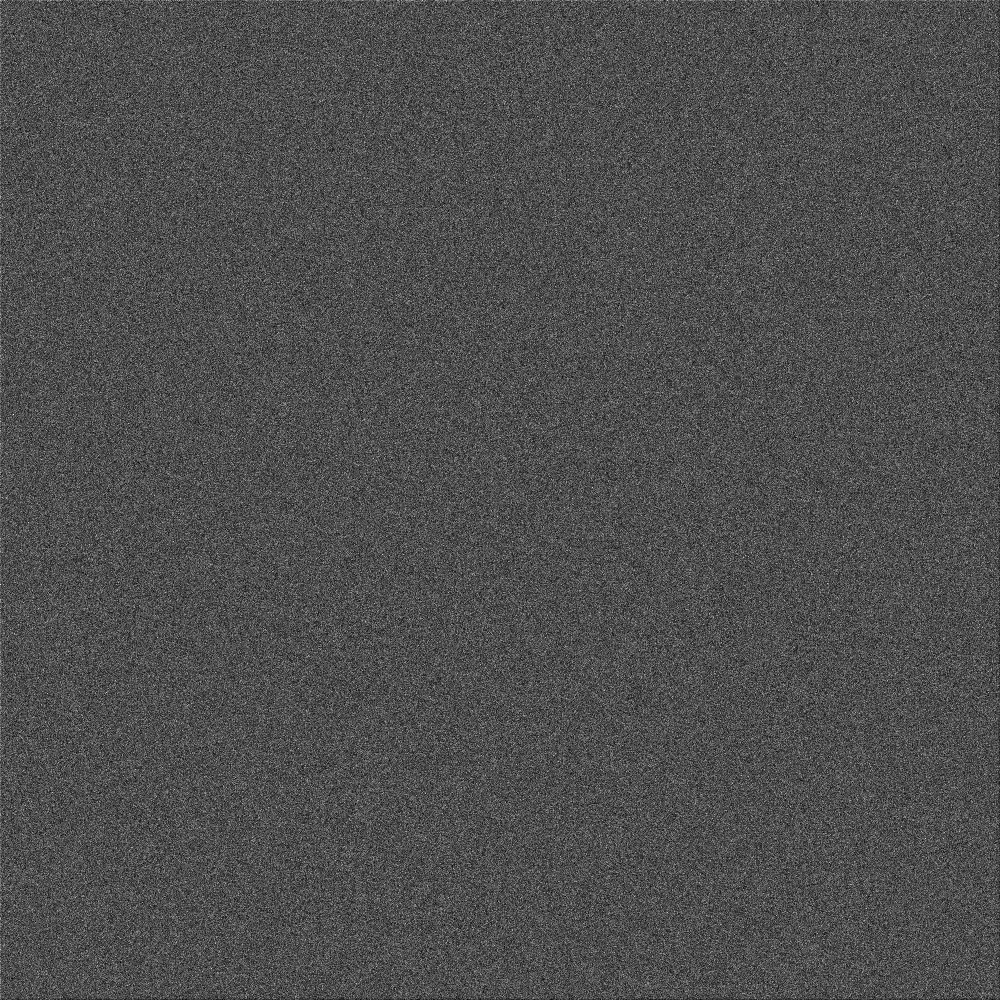

In [9]:
canvas_return = np.array(canvas.get())
canvas_return = np.reshape(canvas_return,(1000,1000))
print(canvas_return)
max = canvas_return.max()
img = Image.fromarray(np.uint8(canvas_return/max * (255)) , 'L')
img.show()
display(img)

In [10]:
for i in range(0,5):
  sum_vector(queue, (n,), None, a.data, b.data)
to_canvas(queue,(n,),None,a.data,canvas.data)
force_arr = cl.array.zeros(queue, 1000*1000, dtype=cltypes.float)
force_calc(queue,((1000*1000),),None,canvas.data,force_arr.data)

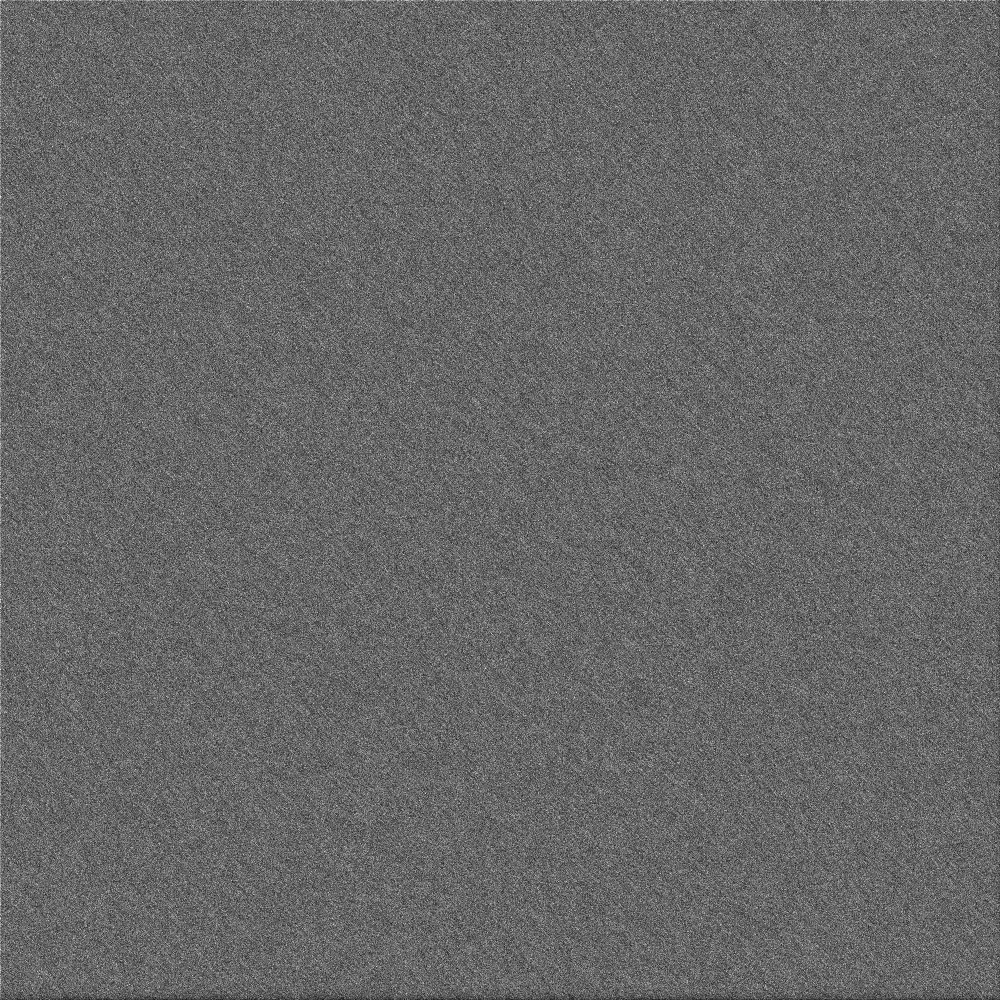

In [11]:
canvas_return = np.array(canvas.get())
canvas_return = np.reshape(canvas_return,(1000,1000))
max = canvas_return.max()
img = Image.fromarray(np.uint8(canvas_return/max * (255)) , 'L')
img.show()
display(img)

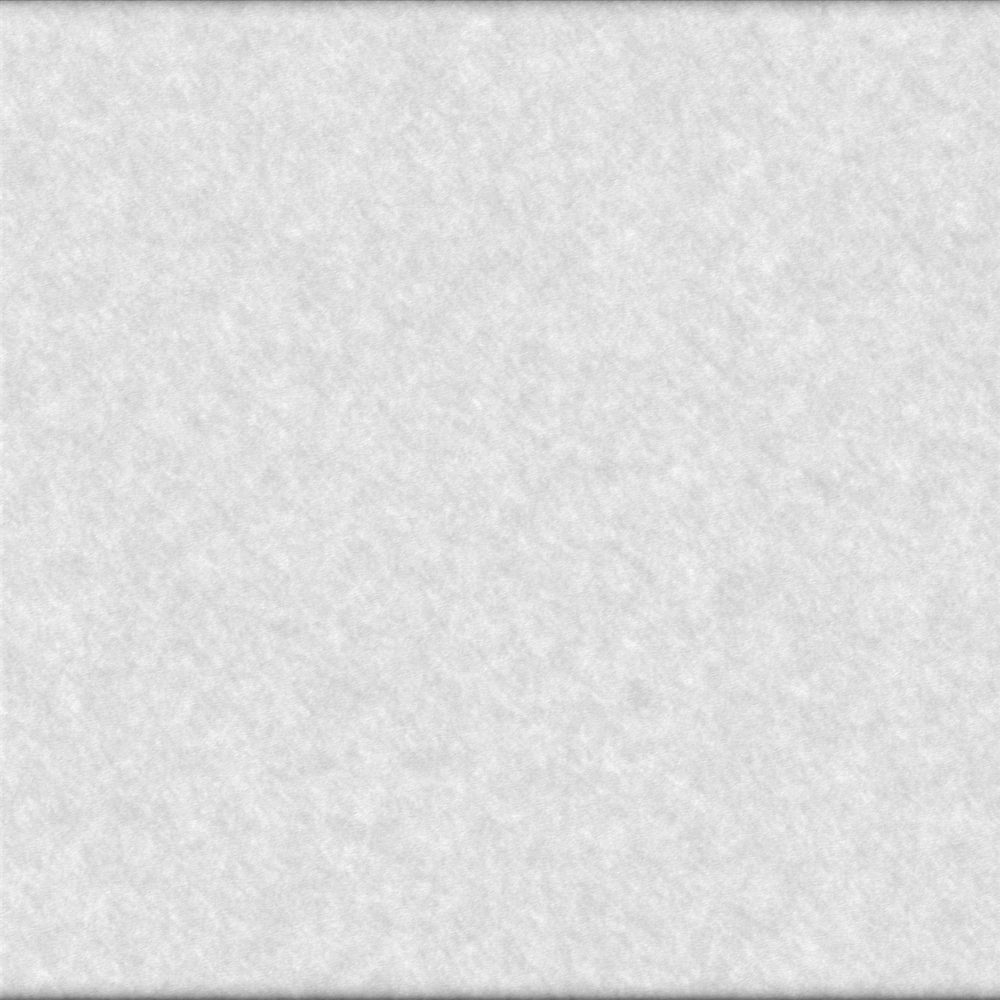

In [12]:
force_return = np.array(force_arr.get())
force_return = np.reshape(force_return,(1000,1000))
max = force_return.max()
img = Image.fromarray(np.uint8(force_return/max * (255)) , 'L')
img.show()
display(img)